# Remora ionic current analysis for tRNAs

This notebooks aims to apply signal alignment using Remora's 'dwell_penalty' algorithm with subsequent statistical comparison of trimmed mean signal levels per base positions, anchored on the reference sequences.
Content of this notebook:
1. Import of required python packages
2. Functions
3. Data loading
4. Signal Alignment
5. Statistical comparison
6. Visualisation

This is mainly based on the Remora API notebooks (https://github.com/nanoporetech/remora/tree/master/notebooks)

## 1. Import of required python packages

In [40]:
# ---- General packages ----
import logging
import pickle
import random
import numpy as np
import pandas as pd
import pingouin as pg
from datetime import datetime
from pathlib import Path
import polars as pl
import patchworklib as pw

# ---- For plotting ----
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns


# ---- Statistical testing ----
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# ---- Specific packages for input ----
import pod5
from pod5 import DatasetReader
import pysam
from remora import io, refine_signal_map, util

# Silence Remora DEBUG messages
logging.getLogger("Remora").setLevel(logging.INFO)


## 2. Functions

### Analysis functions

#### For bootstrapping the IVT sample

Due to unequal sample sizes, we used bootstrapping in which multiple samples of the IVT-tRNA sample were drawn with comparable sample size to the biological sample.

In [2]:
class FilteredReadIndexedBam(io.ReadIndexedBam):
    def __init__(self, bam_path, read_names_to_keep):
        super().__init__(bam_path)
        self.read_names_to_keep = read_names_to_keep

    def fetch(self, *args, **kwargs):
        for read in super().fetch(*args, **kwargs):
            if read.query_name in self.read_names_to_keep:
                yield read

In [3]:
def take_samples_read_ids(
    bam_path,
    sample_size=60,
    number_of_samples=50
):
    """
    Aim: create subsamples based on sample drawing of read-IDs.

    Parameters:
        - bam_path: the file path of the bam file of the IVT sample
        - sample_size: the required subsample size, comparable to biological sample
        - number_of_samples: the required number of subsamples
    """
    
    # Open BAM and get all read names
    bam_file = pysam.AlignmentFile(bam_path, "rb")
    all_read_names = [read.query_name for read in bam_file if not read.is_secondary]
    bam_file.close()

    # Ensure the pool is large enough
    if sample_size > len(all_read_names):
        raise ValueError("Sample size exceeds total number of unique reads available.")

    # Create multiple subsamples
    samples = [
        random.sample(all_read_names, k=sample_size)  # without replacement
        for _ in range(number_of_samples)
    ]

    print(f"Generated {len(samples)} samples, each with {sample_size} unique read IDs.")
    return samples

#### MWU testing

In [4]:
def make_MWU_df(
    ref_reg,
    samples_metrics_1,
    samples_metrics_2,
    min_reads = 30,
    ):
    """
    Make a dataframe in which Mann-Whitney U test is applied per position with FDR-correction.

    Parameters:
        ref_reg: the tRNA reference region of interest
        samples_metrics_1/2: metric dicts for each sample, including the trimmmed means
        min_reads: the minimum amount of reads used in analysis (only testing for significance for positions with enough reads)
    """
  
    trimmean_data_1= pd.DataFrame(samples_metrics_1[0]['trimmean'])
    trimmean_data_1.columns = range(ref_reg.start, ref_reg.end)
    print(f"The number of reads in sample 1: {trimmean_data_1.shape[0]}, the number of positions: {trimmean_data_1.shape[1]}")
    trimmean_data_2= pd.DataFrame(samples_metrics_2[0]['trimmean'])
    trimmean_data_2.columns = range(ref_reg.start, ref_reg.end)
    print(f"The number of reads in sample 2: {trimmean_data_2.shape[0]}, the number of positions: {trimmean_data_2.shape[1]}")

    results = []
    for col in trimmean_data_1.columns:
        ### Per position drop the reads for which no signal value exists
        data_1=  trimmean_data_1[col].dropna()
        data_2 =  trimmean_data_2[col].dropna()
        ### When both samples have at least the minimum amount of reads calculate the Mann-Whitney-U test
        if (len(data_1) >= min_reads) and (len(data_2) >= min_reads):
            result_mwu = pg.mwu(data_1, data_2, alternative='two-sided')
            stat = result_mwu['U-val'].values[0]
            pval = result_mwu['p-val'].values[0]
            RBC = result_mwu['RBC'].values[0]

            results.append({'position': col, 
                            'num_sample_1': len(data_1),
                            'num_sample_2': len(data_2),
                            'median_trimmean_1': np.median(data_1),
                            'median_trimmean_2': np.median(data_2),
                            'sd_trimmean_1': np.std(data_1, ddof= 1),
                            'sd_trimmean_2': np.std(data_2, ddof= 1),
                            'p_value': pval,
                            'RBC': RBC})

    results_df = pd.DataFrame(results)

    ### Adjust the p-values for multiple hypotheses testing
    pvals = results_df['p_value']
    _, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh', alpha = 0.01)

    results_df['adjusted_p_value'] = pvals_corrected
    return results_df

In [5]:
def compute_MWU_results(
    ref_reg,
    samples_metrics_1,
    samples_metrics_2,
    threshold = 0.01,
    min_reads = 30
):
    """
    Filter the positions for which Mann_Whitney_U testing results significant, using make_MWU_df()

    Parameters:
        ref_reg: the tRNA reference region of interest
        samples_metrics_1/2: metric dicts for each sample, including the trimmmed means
        treshold: the alpha-level for the p-value
        min_reads: the minimum amount of reads used in analysis (only testing for significance for positions with enough reads)
        max_reads: the maximum maximum amount of reads used in analysis
    """

    df_Mann_Whitney_U = make_MWU_df(ref_reg, samples_metrics_1, samples_metrics_2, min_reads)
    ### Convert the generated output into a pandas dataframe
    df_Mann_Whitney_U_pd = pd.DataFrame(df_Mann_Whitney_U)

    ### Filter for only significant positions
    filtered_df = df_Mann_Whitney_U_pd[(df_Mann_Whitney_U_pd['adjusted_p_value'] < threshold)]
    print(filtered_df.shape)

    significant_positions = list(filtered_df['position'])

    print(f"Number of significantly different positions for this entry: {len(significant_positions)}")
    
    if len(significant_positions) > 0:
        return filtered_df, significant_positions
    else:
        return None, None

### Plotting functions

#### Line plot

In [6]:
def plot_trimmean_signals_giving_metrics_one_sample_with_seq(
    ref_reg,
    samples_metrics,
    xlim_start=0,
    xlim_end=20,
    signal_type='norm',
    max_reads=None,
    alpha_lines=1/200,
    color = "#009E73",
    highlight_positions=None,
    sequence=None 
):
    """
    Plot trimmean signals for 1 sample per position with sequence shown on x-axis.

    Parameters:
        ref_reg: object with .start, .end, .ctg
        samples_metrics: metric dicts for the sample
        xlim_start/xlim_end: x-axis boundaries
        signal_type: 'norm' or 'pa'
        max_reads: maximum numbers of reads to plot
        alpha_lines: transparency
        color: color of the lines
        highlight_positions: list of positions to highlight
        sequence: (optional) string of nucleotides matching region length
    """
    ## Getting the trimmed mean signal levels of the mapped reads
    trimmean_data = pd.DataFrame(samples_metrics[0]['trimmean'])
    trimmean_data.columns = range(ref_reg.start, ref_reg.end)
    print(f"Shape of metric array: {samples_metrics[0]['trimmean'].shape}")

    # Limit x-axis range
    plot_positions = [pos for pos in trimmean_data.columns if xlim_start <= pos - ref_reg.start < xlim_end]


    plt.figure(figsize=(10, 6))
    
    # If too many reads, draw a random sample
    if max_reads is not None and len(trimmean_data) > max_reads:
        data_to_plot = trimmean_data.sample(n=max_reads, random_state=42)
    else:
        data_to_plot = trimmean_data

    # plot each read as a line
    for i in range(len(data_to_plot)):
        plt.plot(plot_positions, data_to_plot[plot_positions].iloc[i], color=color, alpha=alpha_lines)

    print(f"Plotting {len(data_to_plot)} reads")

    # Show both sequence and position if sequence is provided
    if sequence is not None:
        print(f"The sequence being plotted is {len(sequence[xlim_start:xlim_end])} nt")
        
        ax = plt.gca()  # Get current axis

        # x-axis tick positions
        x_positions = list(range(xlim_start, xlim_end))

        if sequence is not None:
            sequence_slice = sequence[xlim_start:xlim_end]
            if len(sequence_slice) != (xlim_end - xlim_start):
                raise ValueError("Length of sequence slice does not match expected range.")

            # Combine sequence and index labels with newline
            combined_labels = [f"{base}\n{idx}" for idx, base in zip(x_positions, sequence_slice)]
            ax.set_xticks(x_positions)
            ax.set_xticklabels(combined_labels)
            ax.set_xlabel("Base (top) and index (bottom)")
        else:
            ax.set_xticks(x_positions)
            ax.set_xticklabels(x_positions)
            ax.set_xlabel("Sequence index")

    else:
        plt.xticks(plot_positions)

    # Adjust the y-axis to the signal type
    if signal_type == 'norm':
        plt.ylim(-4, 4)
        plt.ylabel('Trimmean (norm)')
    elif signal_type == 'pa':
        plt.ylim(25, 140)
        plt.ylabel('Trimmean (pA)')

    plt.title(ref_reg.ctg)
    plt.grid(color='gray', linestyle='-', linewidth=0.3, alpha=1/30)

    if highlight_positions is not None:
        for position in highlight_positions:
            plt.axvspan(position - 0.5, position + 0.5, color='yellow', alpha=0.3)

    plt.tight_layout()
    plt.show()


In [7]:
def plot_trimmean_signals_two_samples_with_seq(
    ref_reg,
    samples_metrics_1,
    samples_metrics_2,
    xlim_start=0,
    xlim_end=20,
    signal_type='norm',
    max_reads=None,
    alpha_lines=1/200,
    sample_labels=None,
    highlight_positions= None,
    sequence= None
):
    """
    Plot trimmean signals for 2 samples on the same plot.
    
    Parameters:
        ref_reg: object with .start, .end, .ctg
        samples_metrics_1/2/3: metric dicts for each sample
        xlim_start/xlim_end: x-axis boundaries, define region
        signal_type: 'norm' or 'pa'
        max_reads: maximum numbers of reads to plot
        alpha_lines: transparency
        sample_labels: list of 3 labels
        highlight_positions: list of positions to highlight
        sequence: (optional) string of nucleotides matching region length
    """
    trimmean_data_1= pd.DataFrame(samples_metrics_1[0]['trimmean'])
    trimmean_data_1.columns = range(ref_reg.start, ref_reg.end)

    trimmean_data_2= pd.DataFrame(samples_metrics_2[0]['trimmean'])
    trimmean_data_2.columns = range(ref_reg.start, ref_reg.end)
    
    all_metrics = [trimmean_data_1,trimmean_data_2]
    colors = ['#009E73', "#7851A9"]
    if sample_labels is None:
        sample_labels = ['Sample 1', 'Sample 2']

    plt.figure(figsize=(10, 6))

    for idx, sample in enumerate(all_metrics):
        trimmean_data = all_metrics[idx]
        print(f"Shape of metric array {sample_labels[idx]}: {trimmean_data.shape}")

        # Downsample if needed
        if max_reads is not None and len(trimmean_data) > max_reads:
            data_to_plot = trimmean_data.sample(n=max_reads, random_state=42)
        else:
            data_to_plot = trimmean_data

        for i in range(len(data_to_plot)):
            plt.plot(
                data_to_plot.columns,
                data_to_plot.iloc[i],
                color=colors[idx],
                alpha=alpha_lines,
                label=sample_labels[idx] if i == 0 else ""
            )

        print(f"Plotting {len(data_to_plot)} reads for {sample_labels[idx]}")

    # Show both sequence and position if sequence is provided
    if sequence is not None:
        print(f"The sequence being plotted is {len(sequence[xlim_start:xlim_end])} nt")
        
        ax = plt.gca()  # Get current axis

        # x-axis tick positions
        x_positions = list(range(xlim_start, xlim_end))

        if sequence is not None:
            sequence_slice = sequence[xlim_start:xlim_end]
            if len(sequence_slice) != (xlim_end - xlim_start):
                raise ValueError("Length of sequence slice does not match expected range.")

            # Combine sequence and index labels with newline
            combined_labels = [f"{base}\n{idx}" for idx, base in zip(x_positions, sequence_slice)]
            ax.set_xticks(x_positions)
            ax.set_xticklabels(combined_labels)
            ax.set_xlabel("Base (top) and index (bottom)")
        else:
            ax.set_xticks(x_positions)
            ax.set_xticklabels(x_positions)
            ax.set_xlabel("Sequence index")

    else:
        plt.xticks(plot_positions)
        
    plt.xlim(xlim_start, xlim_end)
    # Adjust the y-axis to the signal type
    if signal_type == 'norm':
        plt.ylim(-4, 4)
        plt.ylabel('Trimmean (norm)')
    elif signal_type == 'pa':
        plt.ylim(25, 140)
        plt.ylabel('Trimmean (pA)')

    plt.title(ref_reg.ctg)
    plt.grid(color='gray', linestyle='-', linewidth=0.3, alpha=1/30)
    plt.legend()
    plt.tight_layout()

    if highlight_positions is not None:
        for position in highlight_positions:
            plt.axvspan(position-0.5, position+0.5, color='yellow', alpha=0.3)

    plt.show()

#### Scatterplot

In [8]:
def plot_mean_and_sd_of_trimmean_two_samples(
    ref_reg,
    samples_metrics_1,
    samples_metrics_2,
    xlim_start,
    xlim_end,
    sample_labels,
    signal_type="norm",
    colors=None
):
    """
    Plot dotplots of the mean and sd of the trimmean values per position for 2 samples using matplotlib.
    
    Parameters:
        ref_reg: object with .start, .end, .ctg
        samples_metrics_1/2: metric dicts for each sample
        xlim_start/xlim_end: x-axis boundaries, define region
        sample_labels: list of 2 labels
        signal_type: 'norm' or 'pa'
        colors: colors to use for plotting
    """
    all_metrics = [samples_metrics_1, samples_metrics_2]
    all_means = []
    all_sds = []

    for i, sample in enumerate(all_metrics):
        # For each sample, get the the trimmed mean signal levels
        metrics = sample[0]  # Unpack dict
        trimmean_data = pd.DataFrame(metrics['trimmean'])

        # Calculate the mean per position
        trimmean_mean = trimmean_data.mean()
        df_mean = pd.DataFrame({
            'position': range(len(trimmean_mean)),
            'value': trimmean_mean,
            'label': sample_labels[i]
        })
        all_means.append(df_mean)

        # Calculate the std per position
        trimmean_sd = trimmean_data.std()
        df_sd = pd.DataFrame({
            'position': range(len(trimmean_sd)),
            'value': trimmean_sd,
            'label': sample_labels[i]
        })
        all_sds.append(df_sd)

    # Combine the samples
    df_all_means = pd.concat(all_means, ignore_index=True)
    df_all_sds = pd.concat(all_sds, ignore_index=True)

    # Set y-limits
    if signal_type == 'norm':
        mean_ylim = (-3, 3)
        sd_ylim = (0, 3)
        mean_yticks = np.arange(-3, 3.1, 0.5)
        sd_yticks = np.arange(0, 3.1, 0.2)
    elif signal_type == 'pa':
        mean_ylim = (30, 140)
        sd_ylim = (0, 20)
        mean_yticks = np.arange(30, 141, 10)
        sd_yticks = np.arange(0, 21, 2)
    else:
        raise ValueError("Invalid signal_type. Choose 'norm' or 'pa'.")

    if colors is None:
        colors = ['#009E73', "#7851A9"]

    x_ticks = list(range(xlim_start, xlim_end + 1, 5))

    # Filter by xlim
    df_plot_means = df_all_means.query("position >= @xlim_start and position <= @xlim_end")
    df_plot_sds = df_all_sds.query("position >= @xlim_start and position <= @xlim_end")

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot Mean
    for i, label in enumerate(sample_labels):
        subset = df_plot_means[df_plot_means['label'] == label]
        axs[0].scatter(subset['position'], subset['value'], label=label, color=colors[i], s=15)

    axs[0].set_title(f"{ref_reg.ctg} - Mean Trimmean")
    axs[0].set_ylabel("Mean of trimmed mean")
    axs[0].set_ylim(mean_ylim)
    axs[0].set_yticks(mean_yticks)
    axs[0].legend()
    axs[0].grid(True, alpha = 0.5)

    # Plot SD
    for i, label in enumerate(sample_labels):
        subset = df_plot_sds[df_plot_sds['label'] == label]
        axs[1].scatter(subset['position'], subset['value'], label=label, color=colors[i], s=15)

    
    #axs[1].axhline(y=1, color='red', linestyle='--', linewidth=1, label='SD=1 threshold')

    axs[1].set_title(f"{ref_reg.ctg} - SD Trimmean")
    axs[1].set_xlabel("Reference Position")
    axs[1].set_ylabel("SD of trimmed mean")
    axs[1].set_ylim(sd_ylim)
    axs[1].set_yticks(sd_yticks)
    axs[1].set_xticks(x_ticks)
    axs[1].legend()
    axs[1].grid(True, alpha = 0.5)

    plt.tight_layout()
    plt.show()

    # Print SD summary
    print("Mean SD values per sample:")
    for i, df in enumerate(all_sds):
        print(f"{sample_labels[i]}: {np.mean(df['value']):.4f}")


#### Violin plot

In [9]:
def plot_trimmean_violin_two_samples_with_seq(
    ref_reg,
    samples_metrics_1,
    samples_metrics_2,
    xlim_start=0,
    xlim_end=20,
    signal_type='norm',
    sample_labels=None,
    highlight_positions_one_ionic=None,
    highlight_positions_two_ionic = None,
    highlight_positions_three = None,
    highlight_positions_basecalled = None,
    highlight_positions_basecalled_one = None,
    highlight_positions_excluded = None,
    sequence=None,
    legend = 'yes', title = None
):
    """
    Plot split violin plots of event-level means per position for two samples.

    Parameters:
        samples_metrics_1, samples_metrics_2: lists of dicts with 'trimmean' DataFrames.
        xlim_start/xlim_end: x-axis boundaries, define region
        signal_type: str, 'norm' or 'pa'
        sample_labels: list[str], list of 2 labels
        highlight_positions_one_ionic: list[int], positions predicted by only this ionic current analysis
        highlight_positions_two_ionic: list[int], positions predicted by both ionic current analyses
        highlight_positions_three: list[int], positions predicted by both ionic current analyses and basecalled modification analysis
        highlight_positions_basecalled: list[int], positions predicted by only basecalled modification analysis
        highlight_positions_basecalled_one: list[int], positions predicted by this ionic current analysis and basecalled modification analysis
        highlight_positions_excluded: list[int], positions excluded from the analysis
        sequence: str or None,  optional sequence string for annotated x-axis.
        legend: str 'yes' or 'no', binary to indicate whether to plot the legend
        title: str or None, title of the figure
    """
    df1 = pd.DataFrame(samples_metrics_1[0]['trimmean'])
    df2 = pd.DataFrame(samples_metrics_2[0]['trimmean'])

    dfs = [df1, df2]
    dfs_long = []
    for df, label in zip(dfs, sample_labels):

        # Keep only positions within specified range
        cols_in_range = [pos for pos in df.columns if isinstance(pos, (int, float)) and xlim_start <= pos <= xlim_end]
        df = df.loc[:, cols_in_range]

        # Transform to long format
        df_long = df.melt(var_name="Position", value_name="Trimmean")
        df_long["Sample"] = label
        dfs_long.append(df_long)

    # Combine the samples
    df_all = pd.concat(dfs_long, ignore_index=True)
    
    # Ensure Position is a categorical variable with proper ordering
    full_positions = list(range(xlim_start, xlim_end + 1))
    df_all["Position"] = pd.Categorical(df_all["Position"], categories=full_positions, ordered=True)

    # Configure plot
    custom_palette = {
        sample_labels[0]: '#009E73',  # Biological
        sample_labels[1]: "#7851A9"   # IVT
    }
    fig_width = 10 if legend == 'yes' else 6
    plt.figure(figsize=(fig_width, 4))

    # Highlight positions
    def add_highlight(highlight_list, color, alpha):
        if highlight_list is not None:
            for pos in highlight_list:
                if pos in full_positions:
                    idx = full_positions.index(pos)
                    plt.axvspan(idx - 0.5, idx + 0.5, color=color, alpha=alpha)

    add_highlight(highlight_positions_one_ionic, 'yellow', 0.1)
    add_highlight(highlight_positions_two_ionic, 'orange', 0.2)
    add_highlight(highlight_positions_three, 'red', 0.2)
    add_highlight(highlight_positions_basecalled, 'lightskyblue', 0.3)
    add_highlight(highlight_positions_basecalled_one, 'limegreen', 0.2)
    add_highlight(highlight_positions_excluded, 'grey', 0.2)

    # Plot violins
    ax = sns.violinplot(
        data=df_all,
        x="Position",
        y="Trimmean",
        hue="Sample",
        palette=custom_palette,
        split=True,
        inner="quartile",
        linewidth=0.8,
        scale="width",
        bw=0.2
    )
    plt.xlim(-0.5, len(full_positions) - 0.5)

    # X-axis
    if sequence is not None:
        sequence_slice = sequence[xlim_start:xlim_end+1]
        combined_labels = [f"{base}\n{pos}" for base, pos in zip(sequence_slice, full_positions)]
        ax.set_xticks(range(len(full_positions)))
        ax.set_xticklabels(combined_labels, fontsize=14)
        ax.set_xlabel("Base (top) and position (bottom)", fontsize=14)
    else:
        ax.set_xlabel("Position", fontsize=14)

    # Y-axis
    plt.ylim(-4, 4)
    plt.ylabel(f"Mean signal level ({signal_type})", fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ytick_vals = np.arange(-4, 4.2, 0.5)
    ytick_labels = [str(val) if val % 1 == 0 else "" for val in ytick_vals]
    plt.yticks(ytick_vals, ytick_labels)

    # Title and grid
    plt.title(title if title is not None else ref_reg.ctg)
    plt.grid(color='gray', linestyle='-', linewidth=0.3, alpha=1/30)
    plt.grid(axis='y', linestyle='-', linewidth=0.3, alpha=0.7)

    # Plot legend
    sample_handles = [
        mpatches.Patch(color='#009E73', label='Biological'),
        mpatches.Patch(color='#7851A9', label='IVT')
    ]
    legend_handles = []
    if highlight_positions_one_ionic is not None:
        legend_handles.append(mpatches.Patch(color='yellow', alpha=0.1, label='Predicted by one ionic current analysis'))
    if highlight_positions_two_ionic is not None:
        legend_handles.append(mpatches.Patch(color='orange', alpha=0.2, label='Predicted by both ionic current analyses'))
    if highlight_positions_basecalled is not None:
        legend_handles.append(mpatches.Patch(color='lightskyblue', alpha=0.3, label='Predicted by modification basecalling'))
    if highlight_positions_three is not None:
        legend_handles.append(mpatches.Patch(color='red', alpha=0.2, label='Predicted by all three analyses'))
    if highlight_positions_basecalled_one is not None:
        legend_handles.append(mpatches.Patch(color='limegreen', alpha=0.2, label='Predicted by ionic + basecalling'))
    if highlight_positions_excluded is not None:
        legend_handles.append(mpatches.Patch(color='grey', alpha=0.2, label='Excluded from analyses'))

    if legend == 'yes':
        all_handles = sample_handles + legend_handles
        ax.legend(
            handles=all_handles,
            labels=[h.get_label() for h in all_handles],
            fontsize=12,
            bbox_to_anchor=(1.02, 1),
            ncol=2,
            loc='upper left',
            borderaxespad=0
        )
    elif legend == 'no':
        ax.legend_.remove()

    # Show
    plt.tight_layout()
    plt.show()


## 3. Data loading

For both samples, the following is required:
- Pod5 file including the raw (unbasecalled) reads generated by RNA004-ONT sequecning
- Bam file including the basecalled, map reads. When using BWA-MEM sequence alignment, the bam file needs to be prepare using the bam_preparation python script in order to include both sequence alignments tags and move table tags.

In [10]:
start_time = datetime.now()
print(f"Started at: {start_time}")


own_data_root = Path("/data/fg24045")

print("IVT sample: ")
pod5_dr_IVT = pod5.DatasetReader(own_data_root /"IVT_analysis"/ "complete"/"all_IVTs_merged.pod5") 
bam_fh_IVT = io.ReadIndexedBam(own_data_root/"IVT_analysis"/ "Glu_CTC_1_1"/ "IVT_Glu_CTC_1_1_primary_tagged_f5c_selected.bam")

print("Biological sample")
pod5_dr_bio = pod5.DatasetReader(own_data_root/'tRNA_RNA004_analysis'/'final_data'/'Ctrl_06_complete')
bam_fh_bio = io.ReadIndexedBam(own_data_root/"tRNA_RNA004_analysis"/'final_data'/"Ctrl_06_complete"/
                              "Ctrl_06_complete_f5c_selected.bam")


end_time = datetime.now()
print(f"Finished at: {end_time}")
print(f"Total time taken: {end_time - start_time}")

Started at: 2025-08-11 10:10:51.944913
IVT sample: 


Indexing BAM by parent read id: 18707 Reads [00:00, 50833.81 Reads/s]


Biological sample


Indexing BAM by parent read id: 14019 Reads [00:00, 71382.98 Reads/s]

Finished at: 2025-08-11 10:10:52.522818
Total time taken: 0:00:00.577905


### Bootstrapping the IVT-sample

In [11]:
bam_path = own_data_root/"IVT_analysis"/ "Glu_CTC_1_1"/ "IVT_Glu_CTC_1_1_primary_tagged_f5c_selected.bam"
subsamples = take_samples_read_ids(
    bam_path,
    sample_size=360,
    number_of_samples=50
)
# Save the created subsamples as pickle for future usage and for usage in f5c's analysis
with open("subsamples_IVT_Glu_CTC_1.pkl", "wb") as f:
    pickle.dump(subsamples, f)


Generated 50 samples, each with 360 unique read IDs.


### Loading the generated subsamples

In [12]:
with open("/data/fg24045/tRNA_RNA004_analysis/final_data/Ctrl_06_complete/notebooks/subsamples_IVT_Glu_CTC_1.pkl", "rb") as f:
    subsamples = pickle.load(f)

### Checking the input data

Define the tRNA-region of interest

In [13]:
ref_reg = io.RefRegion(ctg="Homo_sapiens_tRNA-Glu-CTC-1-1", strand="+", start=0, end=72)

Check whether all the reads stored in the bam file have corresponding entry within the pod5 file. This is required for downstream analysis.

In [14]:
bam_reads_bio = io.get_reg_bam_reads(ref_reg, bam_fh_bio)
print(f"The number of bam reads for biological sample: {len(bam_reads_bio)}")
io_reads_bio = io.get_io_reads(bam_reads_bio, pod5_dr_bio)
print(f"The number of io reads for biological sample: {len(io_reads_bio)}")


bam_reads_IVT = io.get_reg_bam_reads(ref_reg, bam_fh_IVT)
print(f"The number of bam reads for IVT: {len(bam_reads_IVT)}")
io_reads_IVT = io.get_io_reads(bam_reads_IVT, pod5_dr_IVT)
print(f"The number of io reads for IVT: {len(io_reads_IVT)}")

The number of bam reads for biological sample: 361
The number of io reads for biological sample: 361
The number of bam reads for IVT: 18707
The number of io reads for IVT: 18707


## 4. Signal Alignment

### Define the signal map refiner
First the kmer_model table need to be loaded, which is obtained from the kmer_models repository of ONT (https://github.com/nanoporetech/kmer_models/tree/master)

In [15]:
level_table = own_data_root / "IVT_analysis"/"Leu_CAA_1_1"/"9mer_levels_v1.txt"

Thereafter, the signal map refiner is defined. For this adjustments within the function rescale() in refine_signal_map.py (start at line 486) are made to enable more inclusive precise rescaling (scale_iters =1):
- dwell_filter_pctls is set to (2, 98)
- edge_filter_bases is set to 5
- min_levels is set to 0

In [16]:
sig_map_refiner = refine_signal_map.SigMapRefiner(
    kmer_model_filename=level_table,
    do_rough_rescale=True,
    scale_iters=1,
    do_fix_guage=True,
    sd_params=(50, 15, 1.5),
    half_bandwidth = 10
)
print(sig_map_refiner)
print(f"The parameters of the dwell_penalty algorithm are set to: {sig_map_refiner.sd_params}")

# Assigning the 6th base within each k-mer as dominant in order to convert signals-per-kmer to signals-per-base
sig_map_refiner.center_idx = 5
print(f"The index of the central base within k-mer is set to: {sig_map_refiner.center_idx}")

Loaded 9-mer table with 4 central position. Rough re-scaling will be executed. 1 rounds of signal mapping refinement followed by precise re-scaling will be executed. Signal mapping refinement will be executed using the dwell_penalty refinement method (band half width: 10). Short dwell penalty array set to [3750.  3601.5 3456.  3313.5 3174.  3037.5 2904.  2773.5 2646.  2521.5
 2400.  2281.5 2166.  2053.5 1944. ].
The parameters of the dwell_penalty algorithm are set to: (50, 15, 1.5)
The index of the central base within k-mer is set to: 5


### Calculating the trimmed mean signal levels

Subsequently, the set signal alignment refiner is applied and the dwell, trimmed mean and trimmed standard deviation of the signals per reference base position is calculated for all the mapped reads per sample.

#### For biological sample

In [17]:
start_time = datetime.now()
print(f"Started at: {start_time}")
samples_metrics_bio, all_bam_reads = io.get_ref_reg_samples_metrics(
    ref_reg,
    [(pod5_dr_bio, bam_fh_bio)],
    metric="dwell_trimmean_trimsd",
    sig_map_refiner=sig_map_refiner, signal_type = 'norm'
)
print(f"Metrics computed: {', '.join(samples_metrics_bio[0].keys())}")
print(f"Shape of metric array: {samples_metrics_bio[0]['trimmean'].shape}")
# The rows are the reads, the columns are the reference positions
end_time = datetime.now()
print(f"Ended at: {end_time}")

Started at: 2025-08-11 10:11:06.620790
Metrics computed: dwell, trimmean, trimsd
Shape of metric array: (361, 72)
Ended at: 2025-08-11 10:11:11.208394


#### For IVT sample

In [18]:
start_time = datetime.now()
print(f"Started at: {start_time}")
samples_metrics_IVT, all_bam_reads = io.get_ref_reg_samples_metrics(
    ref_reg,
    [(pod5_dr_IVT, bam_fh_IVT)],
    metric="dwell_trimmean_trimsd",
    sig_map_refiner=sig_map_refiner, signal_type = 'norm'
)
print(f"Metrics computed: {', '.join(samples_metrics_IVT[0].keys())}")
print(f"Shape of metric array: {samples_metrics_IVT[0]['trimmean'].shape}")
# The rows are the reads, the columns are the reference positions
end_time = datetime.now()
print(f"Ended at: {end_time}")

Started at: 2025-08-11 10:11:11.215020
Metrics computed: dwell, trimmean, trimsd
Shape of metric array: (18707, 72)
Ended at: 2025-08-11 10:12:48.503206


## 5. Statistical comparison

The trimmed mean signal levels between the biological and IVT sample are compared per reference position using Mann-Whitney-U testing.

### MWU testing with bootstrapping

In [19]:
start_time = datetime.now()
print(f"Started at: {start_time}")

all_MWU_results = []
# For each subsample of IVT-sample a MWU-test is conducted with the biological sample.
for i, subsample in enumerate(subsamples):
    # subsample is a list of 50 read ids
    # For each create an FilteredReadIndexedBam object
    subsample_bam = FilteredReadIndexedBam(bam_path, subsample)

    # Compute the samples_metrics for this subsample
    print(f"Computing sample metrics for IVT subsample number  {i + 1}")
    samples_metrics_IVT_norm_subsample, all_bam_reads = io.get_ref_reg_samples_metrics(
        ref_reg,
        [(pod5_dr_IVT, subsample_bam)],
        metric="dwell_trimmean_trimsd",
        sig_map_refiner=sig_map_refiner,
        signal_type='norm'
        )

    # Calculate the MWU-statistic for Ctrl vs. this subsample of IVT
    print("Computing the MWU-statistics for Ctrl with this subsample of IVT-data")
    MWU_results_subsample_df, MWU_sig_positions_subsample = compute_MWU_results(
        ref_reg,
        samples_metrics_1 = samples_metrics_bio,
        samples_metrics_2 = samples_metrics_IVT_norm_subsample,
        min_reads = 30)
    if MWU_sig_positions_subsample != None:
        MWU_results_subsample_df['subsample'] = i  # tag which subsample this is from
        all_MWU_results.append(MWU_results_subsample_df)
print('Done with calculating all the MWU-tests')
combined_df = pd.concat(all_MWU_results, ignore_index=True)

# Count how many times each position is significant
position_counts = combined_df['position'].value_counts()

# Filter all results for only the stable positions, i.e. positions which returned significant in 90% of the bootstrapped subsamples
stable_positions = position_counts[position_counts >= 0.9 * 50].index  # 90% of 50 subsamples
stable_results = combined_df[combined_df['position'].isin(stable_positions)]

# Summarize, e.g., mean and std of p-value, RBC, and medians
print('Summarizing the MWU-results')
summary = stable_results.groupby('position').agg({
    'p_value': ['mean', 'std'],
    'adjusted_p_value': ['mean', 'std'],
    'RBC': ['mean', 'std'],
    'median_trimmean_1': ['mean', 'std'],
    'median_trimmean_2': ['mean', 'std'],
    'num_sample_1': 'mean',
    'num_sample_2': 'mean'
}).reset_index()
summary.columns = [
    'position',
    'pval_mean', 'pval_std',
    'adjusted_pval_mean', 'adjusted_pval_std',
    'RBC_mean', 'RBC_std',
    'median_trimmean_1_mean', 'median_trimmean_1_std',
    'median_trimmean_2_mean', 'median_trimmean_2_std',
    'num_sample_1_mean',
    'num_sample_2_mean'
]

end_time = datetime.now()
print(f"Ended at: {end_time}")

Started at: 2025-08-11 10:12:48.512082


Indexing BAM by parent read id: 18707 Reads [00:00, 45527.91 Reads/s]


Computing sample metrics for IVT subsample number  1
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 77144.75 Reads/s]


Computing sample metrics for IVT subsample number  2
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(52, 10)
Number of significantly different positions for this entry: 52


Indexing BAM by parent read id: 18707 Reads [00:00, 77964.03 Reads/s]


Computing sample metrics for IVT subsample number  3
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(51, 10)
Number of significantly different positions for this entry: 51


Indexing BAM by parent read id: 18707 Reads [00:00, 77778.40 Reads/s]


Computing sample metrics for IVT subsample number  4
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 76443.14 Reads/s]


Computing sample metrics for IVT subsample number  5
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(52, 10)
Number of significantly different positions for this entry: 52


Indexing BAM by parent read id: 18707 Reads [00:00, 77375.87 Reads/s]


Computing sample metrics for IVT subsample number  6
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 45944.89 Reads/s]


Computing sample metrics for IVT subsample number  7
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 77647.70 Reads/s]


Computing sample metrics for IVT subsample number  8
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(50, 10)
Number of significantly different positions for this entry: 50


Indexing BAM by parent read id: 18707 Reads [00:00, 77465.40 Reads/s]


Computing sample metrics for IVT subsample number  9
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 77888.34 Reads/s]


Computing sample metrics for IVT subsample number  10
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(52, 10)
Number of significantly different positions for this entry: 52


Indexing BAM by parent read id: 18707 Reads [00:00, 77481.92 Reads/s]


Computing sample metrics for IVT subsample number  11
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 77622.66 Reads/s]


Computing sample metrics for IVT subsample number  12
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(55, 10)
Number of significantly different positions for this entry: 55


Indexing BAM by parent read id: 18707 Reads [00:00, 45976.93 Reads/s]


Computing sample metrics for IVT subsample number  13
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 77335.07 Reads/s]


Computing sample metrics for IVT subsample number  14
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 77999.61 Reads/s]


Computing sample metrics for IVT subsample number  15
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(54, 10)
Number of significantly different positions for this entry: 54


Indexing BAM by parent read id: 18707 Reads [00:00, 78326.63 Reads/s]


Computing sample metrics for IVT subsample number  16
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(52, 10)
Number of significantly different positions for this entry: 52


Indexing BAM by parent read id: 18707 Reads [00:00, 77351.92 Reads/s]


Computing sample metrics for IVT subsample number  17
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 77958.14 Reads/s]


Computing sample metrics for IVT subsample number  18
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(51, 10)
Number of significantly different positions for this entry: 51


Indexing BAM by parent read id: 18707 Reads [00:00, 45741.70 Reads/s]


Computing sample metrics for IVT subsample number  19
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(55, 10)
Number of significantly different positions for this entry: 55


Indexing BAM by parent read id: 18707 Reads [00:00, 77643.78 Reads/s]


Computing sample metrics for IVT subsample number  20
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(52, 10)
Number of significantly different positions for this entry: 52


Indexing BAM by parent read id: 18707 Reads [00:00, 77520.58 Reads/s]


Computing sample metrics for IVT subsample number  21
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(54, 10)
Number of significantly different positions for this entry: 54


Indexing BAM by parent read id: 18707 Reads [00:00, 77423.51 Reads/s]


Computing sample metrics for IVT subsample number  22
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 77510.01 Reads/s]


Computing sample metrics for IVT subsample number  23
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 78003.02 Reads/s]


Computing sample metrics for IVT subsample number  24
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(52, 10)
Number of significantly different positions for this entry: 52


Indexing BAM by parent read id: 18707 Reads [00:00, 77321.73 Reads/s]


Computing sample metrics for IVT subsample number  25
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(49, 10)
Number of significantly different positions for this entry: 49


Indexing BAM by parent read id: 18707 Reads [00:00, 77709.91 Reads/s]


Computing sample metrics for IVT subsample number  26
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(47, 10)
Number of significantly different positions for this entry: 47


Indexing BAM by parent read id: 18707 Reads [00:00, 77314.04 Reads/s]


Computing sample metrics for IVT subsample number  27
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(51, 10)
Number of significantly different positions for this entry: 51


Indexing BAM by parent read id: 18707 Reads [00:00, 76818.32 Reads/s]


Computing sample metrics for IVT subsample number  28
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(50, 10)
Number of significantly different positions for this entry: 50


Indexing BAM by parent read id: 18707 Reads [00:00, 74561.99 Reads/s]


Computing sample metrics for IVT subsample number  29
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 77880.61 Reads/s]


Computing sample metrics for IVT subsample number  30
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(50, 10)
Number of significantly different positions for this entry: 50


Indexing BAM by parent read id: 18707 Reads [00:00, 45831.10 Reads/s]


Computing sample metrics for IVT subsample number  31
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 77629.80 Reads/s]


Computing sample metrics for IVT subsample number  32
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(54, 10)
Number of significantly different positions for this entry: 54


Indexing BAM by parent read id: 18707 Reads [00:00, 77909.14 Reads/s]


Computing sample metrics for IVT subsample number  33
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(54, 10)
Number of significantly different positions for this entry: 54


Indexing BAM by parent read id: 18707 Reads [00:00, 77848.08 Reads/s]


Computing sample metrics for IVT subsample number  34
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(55, 10)
Number of significantly different positions for this entry: 55


Indexing BAM by parent read id: 18707 Reads [00:00, 78183.11 Reads/s]


Computing sample metrics for IVT subsample number  35
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(56, 10)
Number of significantly different positions for this entry: 56


Indexing BAM by parent read id: 18707 Reads [00:00, 77910.69 Reads/s]


Computing sample metrics for IVT subsample number  36
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(52, 10)
Number of significantly different positions for this entry: 52


Indexing BAM by parent read id: 18707 Reads [00:00, 45703.76 Reads/s]


Computing sample metrics for IVT subsample number  37
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 78306.47 Reads/s]


Computing sample metrics for IVT subsample number  38
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 78012.79 Reads/s]


Computing sample metrics for IVT subsample number  39
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(52, 10)
Number of significantly different positions for this entry: 52


Indexing BAM by parent read id: 18707 Reads [00:00, 77457.75 Reads/s]


Computing sample metrics for IVT subsample number  40
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(54, 10)
Number of significantly different positions for this entry: 54


Indexing BAM by parent read id: 18707 Reads [00:00, 77687.45 Reads/s]


Computing sample metrics for IVT subsample number  41
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(49, 10)
Number of significantly different positions for this entry: 49


Indexing BAM by parent read id: 18707 Reads [00:00, 77951.10 Reads/s]


Computing sample metrics for IVT subsample number  42
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(57, 10)
Number of significantly different positions for this entry: 57


Indexing BAM by parent read id: 18707 Reads [00:00, 45851.67 Reads/s]


Computing sample metrics for IVT subsample number  43
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(52, 10)
Number of significantly different positions for this entry: 52


Indexing BAM by parent read id: 18707 Reads [00:00, 77885.94 Reads/s]


Computing sample metrics for IVT subsample number  44
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 78106.68 Reads/s]


Computing sample metrics for IVT subsample number  45
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(54, 10)
Number of significantly different positions for this entry: 54


Indexing BAM by parent read id: 18707 Reads [00:00, 77729.54 Reads/s]


Computing sample metrics for IVT subsample number  46
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(56, 10)
Number of significantly different positions for this entry: 56


Indexing BAM by parent read id: 18707 Reads [00:00, 77000.68 Reads/s]


Computing sample metrics for IVT subsample number  47
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(53, 10)
Number of significantly different positions for this entry: 53


Indexing BAM by parent read id: 18707 Reads [00:00, 77838.27 Reads/s]


Computing sample metrics for IVT subsample number  48
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(55, 10)
Number of significantly different positions for this entry: 55


Indexing BAM by parent read id: 18707 Reads [00:00, 77196.59 Reads/s]


Computing sample metrics for IVT subsample number  49
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(56, 10)
Number of significantly different positions for this entry: 56


Indexing BAM by parent read id: 18707 Reads [00:00, 77905.90 Reads/s]


Computing sample metrics for IVT subsample number  50
Computing the MWU-statistics for Ctrl with this subsample of IVT-data
The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 360, the number of positions: 72
(52, 10)
Number of significantly different positions for this entry: 52
Done with calculating all the MWU-tests
Summarizing the MWU-results
Ended at: 2025-08-11 10:15:15.384415


In [20]:
print(f"MWU-testing results:")

print(f"\tThe number of significant positions: {len(list(summary['position'].values))}")
print(f"\tThe significant positions: {list(summary['position'].values)}")

MWU-testing results:
	The number of significant positions: 46
	The significant positions: [10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32, 34, 35, 36, 37, 38, 42, 46, 47, 48, 51, 52, 53, 55, 56, 57, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71]


#### Export these results

In [21]:
summary.to_csv("/data/fg24045/tRNA_RNA004_analysis/final_data/Ctrl_06_complete/Results_Remora_MWU_subsampling_Glu_CTC_1_1.csv", index=False)

### MWU testing without bootstrapping

In [22]:
MWU_results_df, MWU_sig_positions = compute_MWU_results(
        ref_reg,
        samples_metrics_1 = samples_metrics_bio,
        samples_metrics_2 = samples_metrics_IVT,
        min_reads = 30)
print(f"\nMWU-testing results without bootstrapping:")
print(f"\tThe number of significant positions: {len(MWU_sig_positions)}")
print(f"\tThe significant positions: {list(MWU_sig_positions)}")

The number of reads in sample 1: 361, the number of positions: 72
The number of reads in sample 2: 18707, the number of positions: 72
(58, 10)
Number of significantly different positions for this entry: 58

MWU-testing results without bootstrapping:
	The number of significant positions: 58
	The significant positions: [9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]


## 6. Visualisation

### Some constants to set for plotting

Define the colours to use in plotting

In [23]:
color_bio = "#009E73"
color_IVT = "#7851A9"

Define the sequence of the reference regions of interest

In [24]:
seq_Glu_CTC_1_1 = "TCCCTGGTGGTCTAGTGGTTAGGATTCGGCGCTCTCACCGCCGCGGCCCGGGTTCGATTCCCGGTCAGGGAA"
seq_Gly_GCC_2_1 = "GCATTGGTGGTTCAGTGGTAGAATTCTCGCCTGCCACGCGGGAGGCCCGGGTTCGATTCCCGGCCAATGCA"
seq_Leu_CAA_1_1_WI = "GTCAGGATGGCCGAGTGGTCTAAGGCGCCAGACTCAAGTTCTGGTCTCCAATGGAGGCGTGGGTTCGAATCCCACTTCTGACA"
seq_Leu_CAA_1_1 = "GTCAGGATGGCCGAGTGGTCTAAGGCGCCAGACTCAAGCTAAGCTTCCTCCGCGGTGGGGATTCTGGTCTCCAATGGAGGCGTGGGTTCGAATCCCACTTCTGACA"
seq_Leu_CAA_1_2 = "GTCAGGATGGCCGAGTGGTCTAAGGCGCCAGACTCAAGCTTGGCTTCCTCGTGTTGAGGATTCTGGTCTCCAATGGAGGCGTGGGTTCGAATCCCACTTCTGACA"

### Line plots: the trimmean signal levels per read

#### Biological sample

Started at: 2025-08-11 10:18:44.505953
Shape of metric array: (361, 72)
Plotting 361 reads
The sequence being plotted is 72 nt


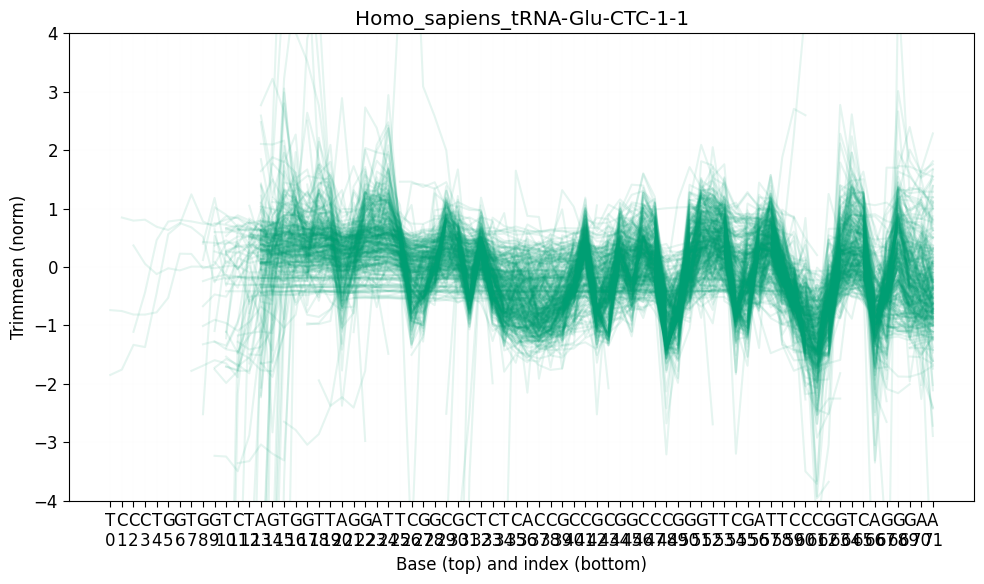

Ended at: 2025-08-11 10:18:45.582925


In [28]:
start_time = datetime.now()
print(f"Started at: {start_time}")
plot_trimmean_signals_giving_metrics_one_sample_with_seq(
    ref_reg,
    samples_metrics_bio, xlim_start = 0, xlim_end = 72,
    max_reads = None,
    signal_type='norm', color = color_bio, alpha_lines = 1/10, highlight_positions = None, sequence = seq_Glu_CTC_1_1)
end_time = datetime.now()
print(f"Ended at: {end_time}")

#### IVT sample

Started at: 2025-08-11 10:18:59.463558
Shape of metric array: (18707, 72)
Plotting 1000 reads
The sequence being plotted is 52 nt


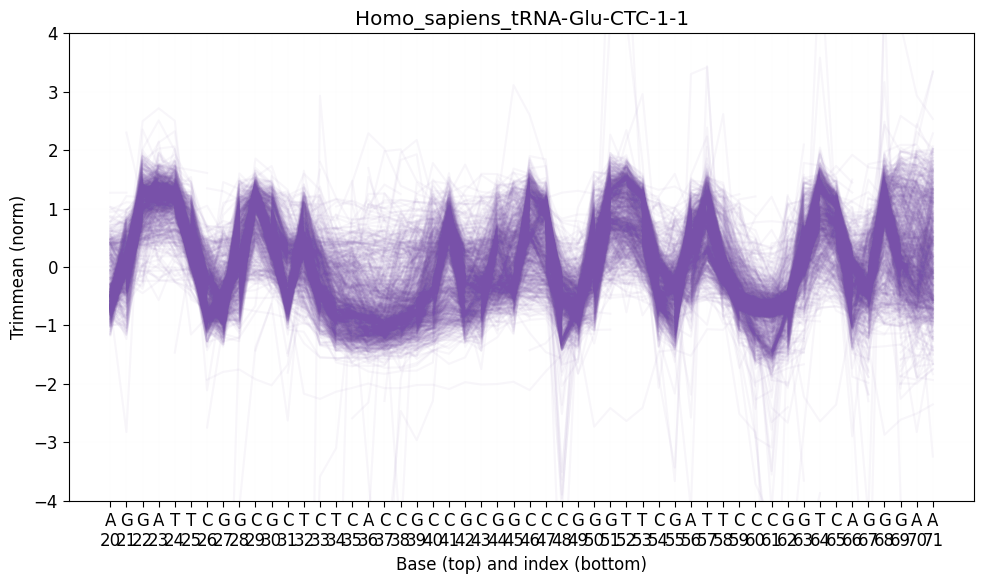

Ended at: 2025-08-11 10:19:01.590842


In [30]:
start_time = datetime.now()
print(f"Started at: {start_time}")
plot_trimmean_signals_giving_metrics_one_sample_with_seq(
    ref_reg,
    samples_metrics_IVT, xlim_start = 20, xlim_end = 72,
    max_reads = 1000,
    signal_type='norm', color = color_IVT, alpha_lines = 1/20, sequence = seq_Glu_CTC_1_1,
    highlight_positions = None)
end_time = datetime.now()
print(f"Ended at: {end_time}")

#### Bio vs. IVT sample

Started at: 2025-08-11 10:19:06.531134
Shape of metric array Control_06: (361, 72)
Plotting 360 reads for Control_06
Shape of metric array IVT_Glu_CTC_1: (18707, 72)
Plotting 360 reads for IVT_Glu_CTC_1
The sequence being plotted is 72 nt


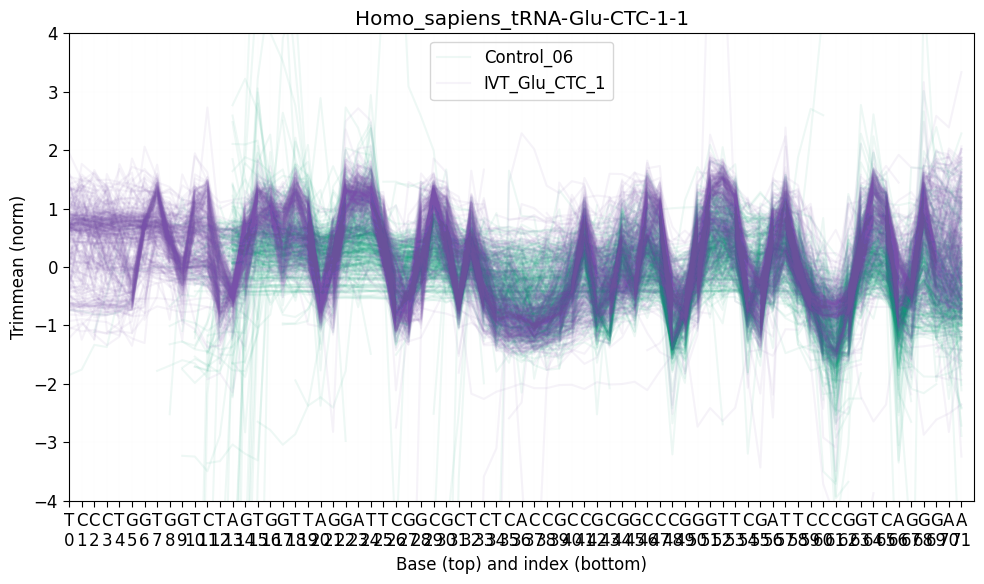

Ended at: 2025-08-11 10:19:09.873004


In [31]:
start_time = datetime.now()
print(f"Started at: {start_time}")
plot_trimmean_signals_two_samples_with_seq(
    ref_reg,
    samples_metrics_1 = samples_metrics_bio,
    samples_metrics_2 = samples_metrics_IVT,
    xlim_start=0,
    xlim_end=72,
    signal_type='norm',
    max_reads=360,
    alpha_lines=1/15,
    sample_labels=['Control_06',"IVT_Glu_CTC_1"], sequence =seq_Glu_CTC_1_1,
    highlight_positions = None
)
end_time = datetime.now()
print(f"Ended at: {end_time}")

### Scatterplots: mean and std of trimmed mean signal levels

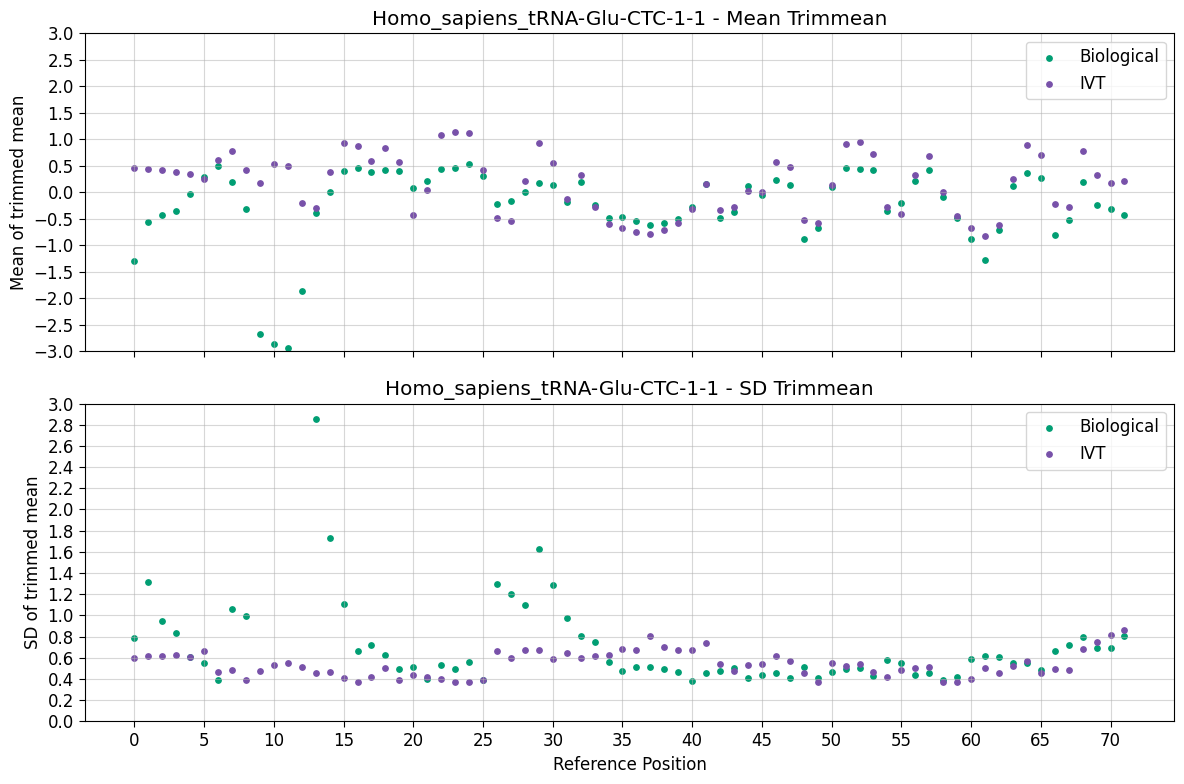

Mean SD values per sample:
Biological: 0.9683
IVT: 0.5416


In [32]:
plot_mean_and_sd_of_trimmean_two_samples(
    ref_reg,
    samples_metrics_1 = samples_metrics_bio,
    samples_metrics_2 = samples_metrics_IVT,
    xlim_start = 0,
    xlim_end = 72,
    sample_labels=['Biological',"IVT"],
    signal_type="norm"
)

### Violin plots

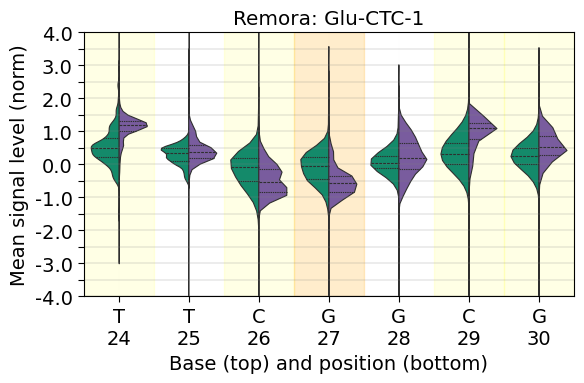

In [37]:
plot_trimmean_violin_two_samples_with_seq(
    ref_reg = ref_reg,
    samples_metrics_1= samples_metrics_bio,
    samples_metrics_2 = samples_metrics_IVT,
    sample_labels=['Biological',"IVT"],
    xlim_start=24,
    xlim_end=30,
    signal_type='norm',
    highlight_positions_one_ionic = [24, 26, 29, 30],
    highlight_positions_two_ionic = [27],
    highlight_positions_three = None,
    highlight_positions_basecalled = None,
    sequence = seq_Glu_CTC_1_1, legend = 'no', title = 'Remora: Glu-CTC-1'
)

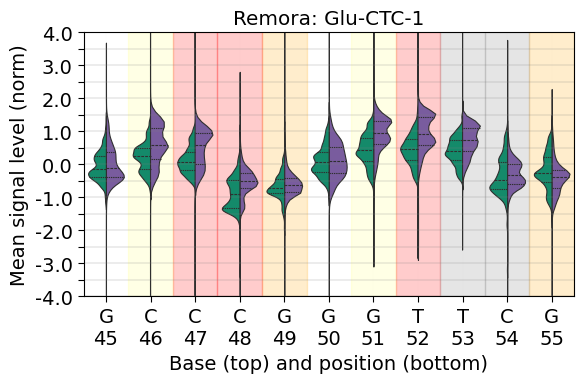

In [38]:
plot_trimmean_violin_two_samples_with_seq(
    ref_reg = ref_reg,
    samples_metrics_1= samples_metrics_bio,
    samples_metrics_2 = samples_metrics_IVT ,
    sample_labels=["Biological","IVT"],
    xlim_start=45,
    xlim_end=55,
    signal_type='norm',

    highlight_positions_one_ionic=[46, 51 ],
    highlight_positions_two_ionic = [49,55],
    highlight_positions_three = [47, 48, 52],
    highlight_positions_basecalled = None,
    highlight_positions_excluded = [53, 54],
    sequence = seq_Glu_CTC_1_1, legend = 'no', title = 'Remora: Glu-CTC-1'
)

## 7. Signal Coverage

In [42]:
def coverage_df(
    list_of_samples_metrics,
    positions_range=[0, 100]):
    """
    Create a DataFrame with coverage per position across multiple samples.

    Parameters:
        list_of_samples_metrics: list of metric dicts for each sample
        positions_range: range of positions to visualize on x-axis
    Returns:
        coverage_results: DataFrame with coverage per position per sample
    """
    filtered_samples = [sample for sample in list_of_samples_metrics if sample is not None]

    # Convert all samples to DataFrames
    sample_dfs = [pd.DataFrame(sample[0]['trimmean']) for sample in filtered_samples]

    positions_ref_reg = list(range(positions_range[0], positions_range[1]))
    results = []

    for pos in positions_ref_reg:
        row = {'position': pos}
        for idx, df in enumerate(sample_dfs):
            col_data = df[pos].dropna() if pos in df.columns else pd.Series(dtype=float)
            row[f'num_sample_{idx+1}'] = len(col_data)
        results.append(row)

    coverage_results = pd.DataFrame(results)
    return coverage_results

In [43]:
def plot_coverage_line(
    coverage_df, 
    sample_labels=None, 
    title=None,
    legend = 'yes',
    alpha_lines = 1/7,
    colors = ['red'],
    ylim=(0, 20000)
):
    """
    Plot coverage line plot for an arbitrary number of samples over positions.

    Parameters:
        coverage_df: DataFrame with columns ['position', 'num_sample_1', ..., 'num_sample_N']
        sample_labels: Optional list of labels for the samples; must match number of sample columns
        title: Optional title for the plot
        ylim: Tuple indicating the range of the y-axis
    """
    plt.figure(figsize=(8, 4))

    # Extract sample columns (exclude 'position')
    sample_columns = [col for col in coverage_df.columns if col != 'position']

    # Use default labels if none provided
    if sample_labels is None:
        sample_labels = sample_columns  # Use column names as labels
    elif len(sample_labels) != len(sample_columns):
        raise ValueError("Length of sample_labels must match the number of sample columns in coverage_df.")


    # Plot each sample line
    for i, col in enumerate(sample_columns):
        plt.plot(
            coverage_df['position'], 
            coverage_df[col], 
            label=sample_labels[i], 
            color=colors[i % len(colors)],
            alpha = alpha_lines,
            linewidth=1
        )

    plt.xlabel('Position', fontsize = 9)
    plt.ylabel('Absolute number of reads', fontsize = 9)
    if title:
        plt.title(title)
    if legend == 'yes':
        plt.legend(loc='center left',  bbox_to_anchor=(1.0, 0.5), fontsize=9)
    plt.ylim(ylim)
    plt.xticks(ticks=range(0, 100, 10),fontsize=9)  # x-axis tick labels
    plt.yticks(fontsize=9) 
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


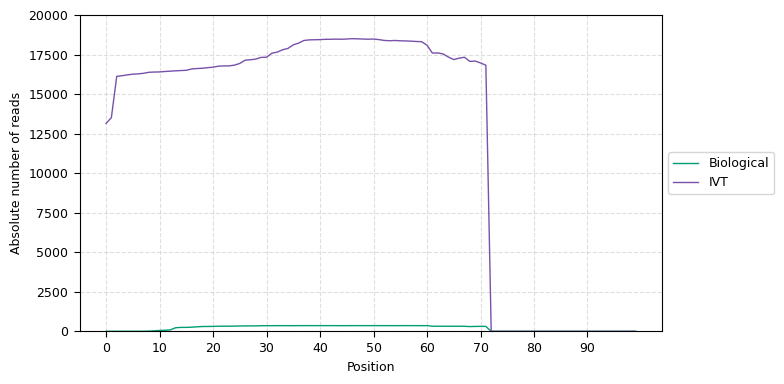

In [55]:
coverage_df_bio = coverage_df(
    [samples_metrics_bio, samples_metrics_IVT],
    positions_range = [0, 100])
plot_coverage_line(coverage_df_bio,
                  sample_labels = ["Biological", 'IVT'],
                  title = None,
                  legend = 'yes',
                  alpha_lines = 1,
                  colors = ["#009E73", "#7851A9"],
                  ylim= (0,20000))

